Machine-Learning Pipeline for BME261L

In [1]:
#Imports
import warnings 
warnings.simplefilter('ignore')
import pandas as pd 
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.decomposition import PCA

#other 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
#initiate confusion matrix holder
confusion_matrices = {}
%matplotlib inline

In [2]:
# report = the return value from sklearn.classification_report()
def report_plot(report, graph_title, bar_width = .3):
    lines = report.split('\n')
    classes = []
    data = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        data.append(v)
    prec = [data[0][0]] + [data[1][0]] + [data[2][0]]
    recall = [data[0][1]] + [data[1][1]] + [data[2][1]]
    fscore = [data[0][2]] + [data[1][2]] + [data[2][2]]
    
    pos1 = [a * (bar_width*4) for a in range(3)]
    pos2 = [a + bar_width for a in pos1]
    pos3 = [a + bar_width for a in pos2]
    plt.bar(pos1, prec, width = bar_width, label="precision")
    plt.bar(pos2, recall, width = bar_width, label="recall")
    plt.bar(pos3, fscore, width = bar_width, label="f-score")
    graph_title = 'Metrics for ' + graph_title
    plt.title(graph_title)
    plt.xlabel("class")
    plt.xticks([a + bar_width + (a * .5 * bar_width) for a in range(3)],
               ["Awake","Light Sleep", "Deep Sleep"])
    plt.legend()

In [3]:
def generate_final_report(classifier_runner, graph_title=""):
    pred_y = classifier_runner(data_X, data_Y)
    report_plot(classification_report(data_Y, pred_y), graph_title)
    confusion_matrices[graph_title] = (data_Y, pred_y)

In [4]:
#Read in CSV
#Names of files
heart_rate_path = '1360686_heartrate.csv'
motion_path = '1360686_acceleration.csv'
label_path = '1360686_labeled_sleep.csv'
#Read in as pandas dataframe
heart_rate = pd.read_csv(heart_rate_path, names=['time','heart_rate', 'time_30'])
motion = pd.read_csv(motion_path, names=['time','motion_x', 'motion_y', 'motion_z', 'time_30'])
labels = pd.read_csv(label_path, names=['time', 'label', 'time_30'])
#drop time 
heart_rate.drop('time', axis=1, inplace=True)
motion.drop('time', axis=1, inplace=True)
labels.drop('time', axis=1, inplace=True)
#preview data
print('HR:', heart_rate.shape)
print('Motion:', motion.shape)
print('Labels:', labels.shape)
#print(heart_rate.head(10))
#print(motion.head(10))
#print(labels.head(10))
#drop extra data from HR and Motion. This will reduce the 
#risk of over-fitting
heart_rate.drop_duplicates(subset='time_30', inplace=True)
motion.drop_duplicates(subset='time_30', inplace=True)
#Combine labels 1 and 2 for 'light sleep' as 1
#Combine labels 3 and 5 for 'deep sleep' as 5
labels.replace(2, 1, inplace=True)
labels.replace(3,5, inplace=True)
print(labels['label'].value_counts())
#Merge data based on time_30. 
data = pd.merge(left=heart_rate, right=labels, on='time_30')
data = pd.merge(left=motion, right=data, on='time_30')
#data.to_csv('test_join.csv') #uncomment to write to csv
data.head(10)


HR: (3592, 2)
Motion: (931576, 4)
Labels: (633, 2)
1    289
5    268
0     76
Name: label, dtype: int64


,motion_x,motion_y,motion_z,time_30,heart_rate,label
0,0.019989,-0.338638,-0.943909,42,75,0
1,-0.022018,-0.062485,-1.000153,43,69,0
2,-0.039764,0.009735,-1.001114,44,68,0
3,-0.038300,0.006317,-1.000595,45,63,0
4,-0.053772,0.097122,-0.995712,46,73,0
5,-0.050827,0.094681,-0.996140,47,62,0
6,-0.053772,0.094192,-0.995224,48,63,0
7,-0.049347,0.093216,-0.996597,49,66,0
8,-0.021133,-0.020493,-1.000687,50,62,0
9,-0.016220,-0.038544,-1.000076,51,66,0


In [5]:
#seperate features from label
data_X = data.iloc[:, 0:5]
data_Y = data.iloc[:, 5]

#drop time_30 since this is not a measured feature
data_X.drop('time_30', axis=1, inplace=True)

#downsample to 54,609 data points
print('New shape of data:', data_X.shape)

New shape of data: (624, 4)


In [6]:
#KNN
def KNN_runner(data_x, data_y):
    import warnings 
    warnings.simplefilter('ignore')
    #Dimensionality reduction
    pca = PCA()
    #create a scaler
    scaler = StandardScaler()

    #create a KNN classifier
    knn = KNeighborsClassifier()
    #create a pipeline that does scaling, then KNN (prevent data leakage)
    pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knn', knn)])
    #Set up parameters to fine tune
    #check nearest neighbors 1-30
    param_grid = {
        'knn__n_neighbors': list(range(1, 30)),
        'pca__n_components': list(range(1,5))
    }
    #Pass the pipeline and the parameters into a GridSearchCV with a 5-fold CV
    clf = GridSearchCV(pipe, param_grid, cv=5)
    clf.fit(data_x, data_y)
    print('Best parameters:\n',
          'n neighbors:', clf.best_params_['knn__n_neighbors'],'\n'
          'PCA n components:', clf.best_params_['pca__n_components'])
    Y_pred = cross_val_predict(clf, data_X, data_Y, cv=5)
    return Y_pred
;

''

Best parameters:
 n neighbors: 12 
PCA n components: 4


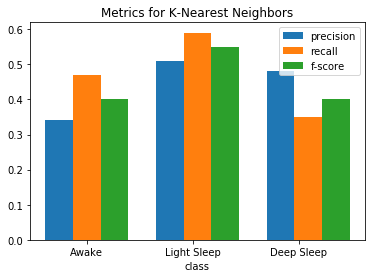

In [7]:
generate_final_report(KNN_runner, 'K-Nearest Neighbors')

In [8]:
#Naive Bayes
def NB_runner(data_x, data_y):
    #create a NB classifier
    clf = GaussianNB()
    #fit with a 10-fold CV
    Y_pred = cross_val_predict(clf, data_X, data_Y, cv=10)
    return Y_pred

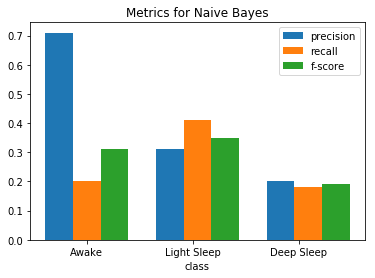

In [9]:
generate_final_report(NB_runner, 'Naive Bayes')

In [10]:
#SVM
def svm_runner(data_x, data_y):
    warnings.simplefilter('ignore')
    #Dimensionality reduction
    pca = PCA()
    #create a scalar
    scaler = StandardScaler()
    #create a SVM classifier
    svm = SVC()
    #create a pipeline that does scaling, then SVM
    pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svm', svm)])
    #Set up parameters to fine tune
    #tune for best kernel
    param_grid = {
        'svm__kernel':['linear', 'rbf', 'poly', 'sigmoid'],
        'pca__n_components' :list(range(1,5))
        }
    #grid search and CV
    clf = GridSearchCV(pipe, param_grid, cv=5)
    clf.fit(data_X, data_Y)
    print('Best parameters:\n',
          'Kernel:', clf.best_params_['svm__kernel'], '\n',
          'PCA n components:', clf.best_params_['pca__n_components'])
    Y_pred = cross_val_predict(clf, data_X, data_Y, cv=5)
    return Y_pred
;

''

Best parameters:
 Kernel: poly 
 PCA n components: 3


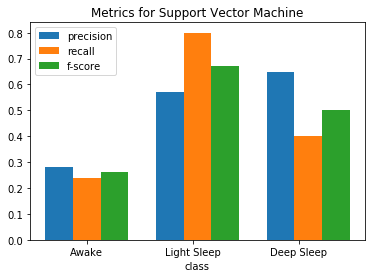

In [11]:
generate_final_report(svm_runner, 'Support Vector Machine')

In [12]:
#Neural Net
def NN_runner(data_x, data_y):
    #create a scalar
    scaler = StandardScaler()
    #dimensionality reduction
    pca = PCA()
    #create a Nueral Net classifier
    mlp = MLPClassifier()
    #create a pipeline that does scaling, then SVM
    pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('mlp', mlp)])
    #Set up parameters to fine tune
    #tune for best hidden layer size and activation
    param_grid = {
        'mlp__hidden_layer_sizes': [(10,), (20,), (30,),
                                    (40,), (50,), (60,)],
        'mlp__activation': ['logistic', 'tanh', 'relu'],
        'pca__n_components': range(1,5)
        }
    #grid search and CV
    clf = GridSearchCV(pipe, param_grid, cv=5)
    clf.fit(data_X, data_Y)
    print('Best parameters:\n',
          'Hidden layer size:', clf.best_params_['mlp__hidden_layer_sizes'],'\n',
          'Activation function:', clf.best_params_['mlp__activation'], '\n',
          'PCA n components:', clf.best_params_['pca__n_components'])
    Y_pred = cross_val_predict(clf, data_X, data_Y, cv=5)
    return Y_pred
;

''

Best parameters:
 Hidden layer size: (50,) 
 Activation function: relu 
 PCA n components: 1


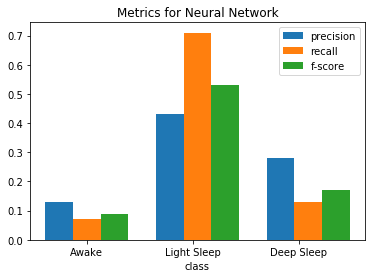

In [13]:
generate_final_report(NN_runner, 'Neural Network')

In [14]:
#Random Forest
def RF_runner(data_x, data_y):
    #create a random forest classifier
    rfc = RFC()
    #Set up parameters to fine tune
    #tune for best max depth, min samples per leaf and max features
    max_depth_lst = list(range(35,56))
    param_grid = {'max_depth': max_depth_lst,
                  'min_samples_leaf': [8, 10, 12],
                  'max_features': ['sqrt', 'log2']}
    #grid search and CV
    clf = GridSearchCV(rfc, param_grid, cv=5)
    clf.fit(data_X, data_Y)
    print('Best parameters:\n',
          'Max depth:', clf.best_params_['max_depth'], '\n',
          'Min samples per leaf:', clf.best_params_['min_samples_leaf'], '\n',
          'Max features:', clf.best_params_['max_features'])
    Y_pred = cross_val_predict(clf, data_X, data_Y, cv=5)
    return Y_pred
;

''

Best parameters:
 Max depth: 39 
 Min samples per leaf: 8 
 Max features: log2


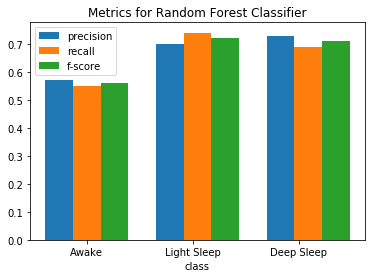

In [15]:
generate_final_report(RF_runner, 'Random Forest Classifier')

In [16]:
#AdaBoostClassifier
def ABC_runner(data_x, data_y):
    #create an AdaBoostClassifier
    abc = ABC()
    #params
    est_lst = list(range(50,251, 25))
    param_grid = {'n_estimators': est_lst}
    #grid search 
    clf = GridSearchCV(abc, param_grid, cv=5)
    clf.fit(data_X, data_Y)
    print('Best parameters:\n',
          'n estimators:', clf.best_params_['n_estimators'])
    #cross validation
    Y_pred = cross_val_predict(clf, data_X, data_Y, cv=5)
    return Y_pred
;

''

Best parameters:
 n estimators: 150


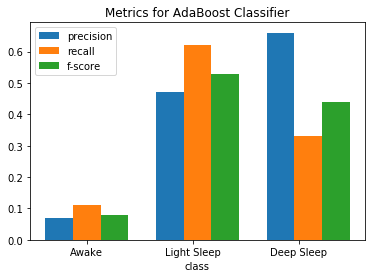

In [17]:
generate_final_report(ABC_runner, 'AdaBoost Classifier')

In [97]:
def final_graph(metric):
    x_labels = confusion_matrices.keys()
    y_label = ""
    x = np.arange(len(x_labels))
    fig, ax = plt.subplots(figsize=(15, 8))
    width = 0.25
    rectlists = []
    if metric == "f1":
        values = [f1_score(a[0], a[1], average=None) for a in confusion_matrices.values()]
        values_awake = [row[0] for row in values]
        values_light_sleep = [row[1] for row in values]
        values_deep_sleep = [row[2] for row in values]
        y_label = "F-1 scores" 
        r1 = np.arange(len(values_awake))
        r2 = [x + 0.25 for x in r1]
        r3 = [x + 0.25 for x in r2]
        awake = ax.bar(r1, values_awake, width, label='Awake')
        light_sleep = ax.bar(r2, values_light_sleep, width, label='Light sleep')
        deep_sleep = ax.bar(r3, values_deep_sleep, width, label='Deep sleep')
        rectlists = [awake, light_sleep, deep_sleep]
        ax.legend()
    elif metric=='accuracy':
        y_label = "Accuracy"
        values = [accuracy_score(a[0],a[1]) for a in confusion_matrices.values()]
        values = [a*100 for a in values]
        accuracies = ax.bar(x, values, width, label=None)
        rectlists = [accuracies]
    
    ax.set_ylabel(y_label)
    ax.set_title("Model Metrics")
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.2f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

    for l in rectlists:
        autolabel(l)

    fig.tight_layout()
;

''

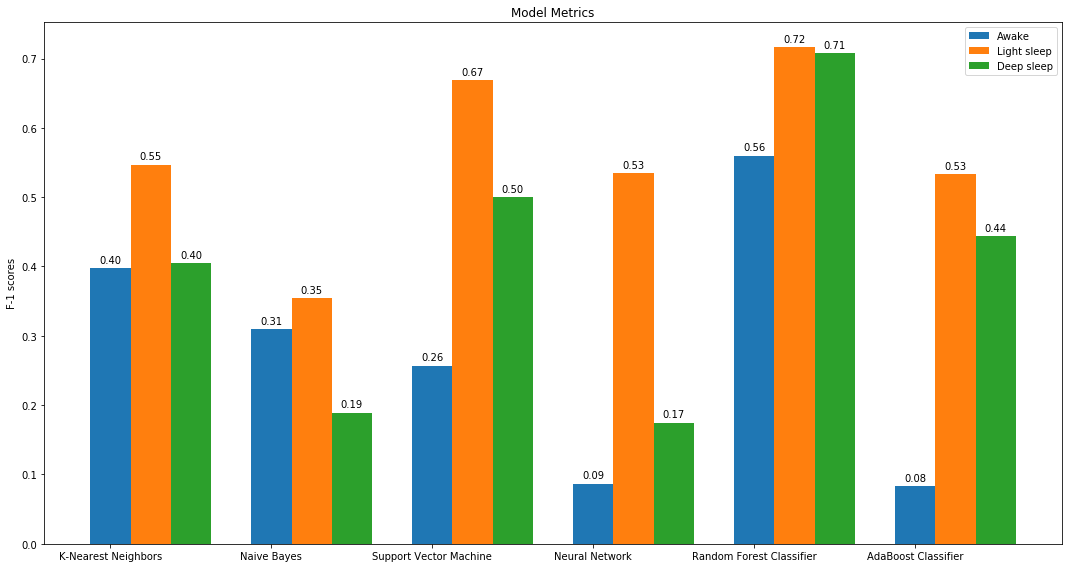

In [98]:
final_graph('f1')

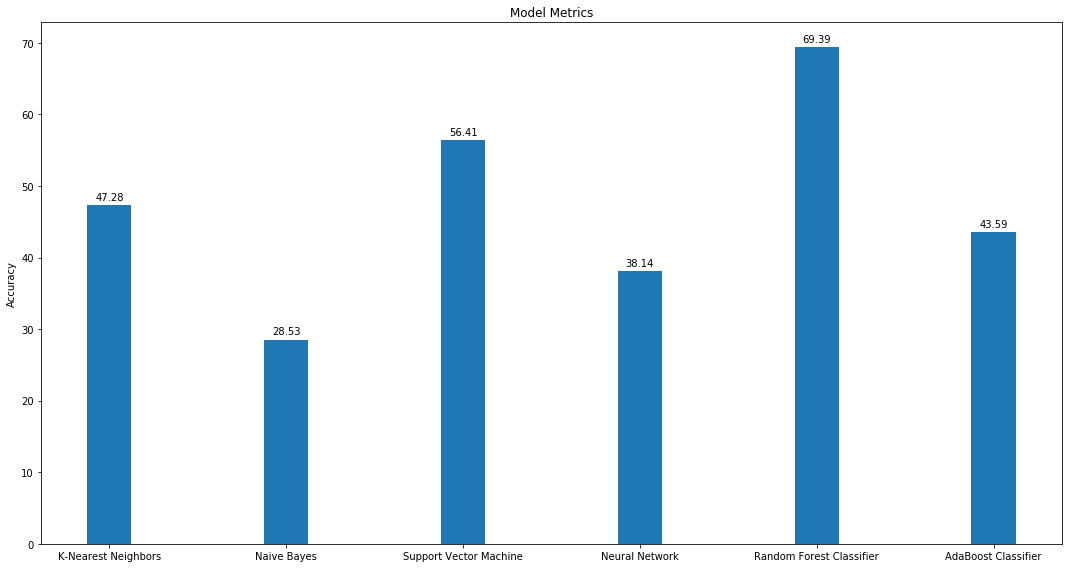

In [99]:
final_graph('accuracy')